In [1]:
import sys
from collections import defaultdict
import datetime
import json
import pandas as pd
import numpy as np

col_delim = ';'

def load(filename):
    with open(filename, 'r', errors='backslashreplace') as f:
        lines = [line.rstrip('\n') for line in f.readlines()]
    return lines

def df_from(headers, lines):
    df = defaultdict(list)
    for line in lines:
        for header, cell in zip(headers, line.split(col_delim)):
            df[header].append(cell)
    return df

def err_log_dataframe(filename):
    headers = ["timestamp", "severity", "UNUSED", "message", "code", "source", "call chain"]
    err_log_dict = df_from(headers, load(filename))
    df = pd.DataFrame.from_dict(err_log_dict)
    df = err_log_timestamp(df)
    relative_time(df)
    return df
    
def err_log_timestamp(df):
    '''Converting timestamp string to datetime in the dataframe.
    '''
    fmt = '%Y%m%d%H%M%S.%f'
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S.%f')
    return df

def split_sensor_message(message):
    '''Splits message column to get relevant sensor data in this to be used to
    create new columns.
    '''
    prefix = "Sensor Data: "
    _, raw_json = message.split(prefix, 1)
    data_point = json.loads(raw_json, strict=False)
    sensor_id = int(data_point["Sensor ID"])
    value = float(data_point["Value (mg/dL)"])
    return pd.Series([sensor_id, value])

def get_sensor_dfs(df):
    '''Take the error log dataframe and filters out sensor data and returns a list of 
    dataframes for individual sensor data (for this data their are only 2 sensors so 2 
    dataframes will be returned)
    '''
    prefix = "Sensor Data: "
    sensor_df = df[df['message'].str.contains(prefix)]
    sensor_df = sensor_df.reset_index(drop=True)
    
    #adding columns for sensor_id and glucose value from the message using split_sensor_message
    sensor_df[['Sensor ID', 'Glucose Value (mg/dL)']] = sensor_df['message'].apply(lambda x: split_sensor_message(x))
    
    sensor_df_list = []
    
    num_sensors = sensor_df['Sensor ID'].nunique()
    for i in range(num_sensors):
        sensor_filtered_df = sensor_df[sensor_df['Sensor ID'] == i]
        sensor_filtered_df = sensor_filtered_df.reset_index(drop=True)

        # If you want everything to be anchored to the same time stamps,
        # leave this commented. It essentially resets the 0-point in the 
        # timestamps to be wherever the minimum time in the filtered dataframe is.
        #relative_time(sensor_filtered_df)
        sensor_df_list.append(sensor_filtered_df)
        
    return sensor_df_list

def relative_time(sensor_df, conversion='m'):
    '''Created a new column for relative time for each log entry (default in minutes) for the
    dataframe sent in the paramater.
    '''
    min_timestamp = (sensor_df['timestamp'].min())
    sensor_df['rel_time'] = sensor_df['timestamp'].apply(lambda x: (x - min_timestamp)/np.timedelta64(1, conversion))
    return sensor_df

def split_pump_message(message, prefix):
    '''Splits message column to get relevant pump data in this to be used to
    create a new column.
    '''
    _, contents = message.split(prefix)
    bucket = contents.split(' ')
    rate = float(bucket[0])
    return rate

def get_pump_df(df, substance=None):
    '''Get a dataframe containing pump rate data, and time in minutes
    '''
    if substance not in {"Insulin", "Dextrose"}:
        raise ValueError("Invalid substance, needs to be either 'Insulin' or 'Dextrose'")
        
    prefix = "changing pump rate to "
    pump_rate_df = df[df['message'].str.contains(prefix)]
    pump_rate_df = pump_rate_df.reset_index(drop=True)

    pump_rate_df["Rate (mL/hr)"] = pump_rate_df['message'].apply(lambda x: split_pump_message(x, prefix))

    return pump_rate_df


def plot_sensor_data(df):
    # Example usage of the sensor dataframes
    import matplotlib.pyplot as plt
    frames = get_sensor_dfs(df)
    for i, frame in enumerate(frames):
        plt.plot(frame["rel_time"], frame["Glucose Value (mg/dL)"], label=f"ID {i}")

    plt.legend(loc='upper right')
    plt.show()

def plot_pump_data(df):
    import matplotlib.pyplot as plt
    substances = ["Insulin"]#, "Dextrose"]
    frames = [get_pump_df(df, substance) for substance in substances]
    for substance, frame in zip(substances, frames):
        plt.plot(frame["rel_time"], frame["Rate (mL/hr)"], label=substance)

    plt.legend(loc='upper right')
    plt.show()

def get_app_setup_info(df):
    '''Get dictionaries containing MR Number, weight, Initial glucose, etc.

    See: Working With IMT Data Products/Application Setup Information Parsing
    for a detailed explanation of this process

    Returns a tuple of dictionaries mapping output parameter names to "String Value" and "Double Value"

    If you want to, for example, access the weight (a floating point value), you can do it like so:
    _, info_floats = get_app_setup_info(df)
    weight = info_floats["Weight"]

    If you want to, for example, access the anonymized patient record number, aka MR Number (a string),
    you can do it like so:
    info_strings, _ = get_app_setup_info(df)
    mr_number = info_strings["MR Number"]
    '''
    app_setup_df = df_filter(df, "message", lambda x: "Output Parameters" in x)
    app_setup_json = app_setup_df["message"][0]
    app_setup_raw = json.loads(app_setup_json)
    app_setup_info_strings = {}
    app_setup_info_floats = {}

    for i in range(8):
        name_key = f"Output Parameters[{i}]:Output Parameter Name"
        string_value_key = f"Output Parameters[{i}]:String Value"
        float_value_key = f"Output Parameters[{i}]:Double Value"

        name = app_setup_raw[name_key]
        s = app_setup_raw[string_value_key]
        d = float(app_setup_raw[float_value_key])

        app_setup_info_strings[name] = s
        app_setup_info_floats[name] = d

    return app_setup_info_strings, app_setup_info_floats

In [2]:
#TO DO REDO THE PLOT FUNCTIONS AND THEN ADD TO GITHUB AND PR TO JEREMY

In [3]:
#creating the dataframe from the dictionary 
err_log_df = err_log_dataframe("IMT_ERROR_LOG_20210718014240.log")
err_log_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time
0,2021-07-18 01:42:40.473112,LOG_INFO,None,Current Git Commit Revision/Hash: aff6f3d65737...,0000,,ApplicationType.lvclass:Record Git Revision.vi...,0.000000
1,2021-07-18 01:42:40.474105,LOG_INFO,None,"IMT Application Configuration: {\t""Disable Sta...",0000,,ApplicationType.lvclass:Record Global Config.v...,0.000017
2,2021-07-18 01:42:40.474105,LOG_INFO,None,"RGVISA Feature: {\t""Use RGVISA?"": ""FALSE""}",0000,,ApplicationType.lvclass:Record RGVISA config.v...,0.000017
3,2021-07-18 01:43:08.246933,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.462897
4,2021-07-18 01:43:35.082033,LOG_DEBUG,None,Attempting to abort VI: RunHardware.lvclass:Us...,1000,Invoke Node in Utilities.lvclass:Abort VI if R...,Utilities.lvclass:Abort VI if Running.vi in Ru...,0.910149


In [4]:
dfs = get_sensor_dfs(err_log_df)

sensor0_df = dfs[0]
sensor1_df = dfs[1]
sensor0_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Sensor ID,Glucose Value (mg/dL)
0,2021-07-18 01:47:45.679785,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,5.086778,0.0,77.0
1,2021-07-18 01:52:47.799057,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,10.122099,0.0,76.0
2,2021-07-18 01:57:50.099517,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,15.160440,0.0,88.0
3,2021-07-18 02:02:52.293190,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,20.197001,0.0,104.0
4,2021-07-18 02:07:54.558325,LOG_INFO,None,"Sensor Data: {\t""Sensor Type"": ""Dexcom G6"",\t""...",0000,,,25.234754,0.0,112.0


In [5]:
pump_rate_df = get_pump_df(err_log_df, substance='Dextrose')
pump_rate_df.head()

,timestamp,severity,UNUSED,message,code,source,call chain,rel_time,Rate (mL/hr)
0,2021-07-18 01:43:42.590149,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,1.035284,0.0
1,2021-07-18 01:43:43.419466,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Insulin, ...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,1.049106,0.0
2,2021-07-18 01:44:52.668798,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,2.203261,0.0
3,2021-07-18 01:44:53.499296,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Insulin, ...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,2.217103,0.0
4,2021-07-18 01:45:52.760831,LOG_DEBUG,None,"changing pump rate to 0.000000 mL/hr Dextrose,...",1073676418,VISA Close in KD_Scientific_lib_2XX_SeriesKD S...,RunHardware.lvclass:Handle Pump User Event.vi:...,3.204795,0.0


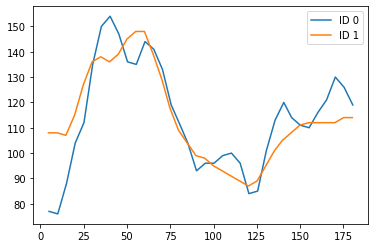

In [6]:
plot_sensor_data(err_log_df)

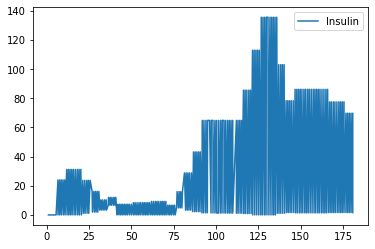

In [7]:
plot_pump_data(err_log_df)